# Calculations with Reference States

## Experimental Reference States: Formation and Mixing Energy

By default, energies calculated with pycalphad (e.g. `GM`, `HM`, etc.) are the absolute energies as defined in the database and are not calculated with respect to any reference state.

pycalphad `Model` objects allow the reference for the pure components to be set to arbitrary phases and temperature/pressure conditions through the `shift_reference_state` method, which creates new properties for the energies that are referenced to the new reference state, `GMR`, `HMR`, `SMR`, and `CPMR`.

### Enthalpy of mixing

The enthalpy of mixing in the liquid, analogous to what would be measured experimentally, is calculated and plotted below with the reference states of the pure elements both set to the liquid phase. No temperature and pressure are specified as we would like the reference state to be calculated with respect to the calculation temperature.

In [1]:
%matplotlib inline

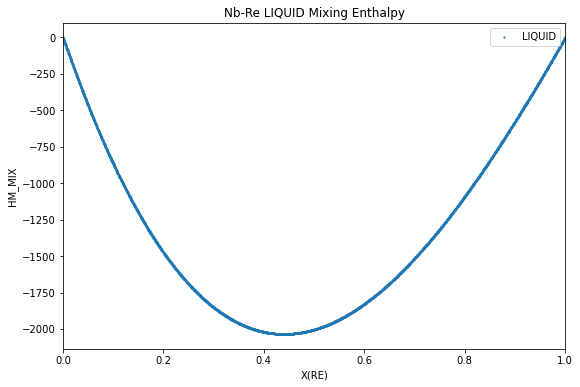

In [2]:
from pycalphad import Database, calculate, Model, ReferenceState, variables as v
import matplotlib.pyplot as plt

dbf = Database("databases/nbre_liu.tdb")
comps = ["NB", "RE", "VA"]

# Create reference states
Nb_ref = ReferenceState("NB", "LIQUID_RENB")
Re_ref = ReferenceState("RE", "LIQUID_RENB")
liq_refstates = [Nb_ref, Re_ref]

# Create the model and shift the reference state
mod_liq = Model(dbf, comps, "LIQUID_RENB")
mod_liq.shift_reference_state(liq_refstates, dbf)
calc_models = {"LIQUID_RENB": mod_liq}

# Calculate HMR for the liquid at 2800 K from X(RE)=0 to X(RE)=1
conds = {v.P: 101325, v.T: 2800, v.X("RE"): (0, 1, 0.01)}
result = calculate(dbf, comps, "LIQUID_RENB", P=101325, T=2800, output="HMR", model=calc_models)

# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
ax.scatter(result.X.sel(component='RE'), result.HMR, marker='.', s=5, label='LIQUID')
ax.set_xlim((0, 1))
ax.set_xlabel('X(RE)')
ax.set_ylabel('HM_MIX')
ax.set_title('Nb-Re LIQUID Mixing Enthalpy')
ax.legend()
plt.show()

### Enthalpy of formation - convex hull

Formation enthalpies are often reported in the literature with respect to the pure elements in their stable phase at 298.15 K. The enthalpy of formation of the phases in equilibrium, analogous to what would be measured experimentally, is calculated and plotted below for T=2800 K, with the reference states of the pure elements both set to the stable phases and fixed at 298.15 K and 1 atm.

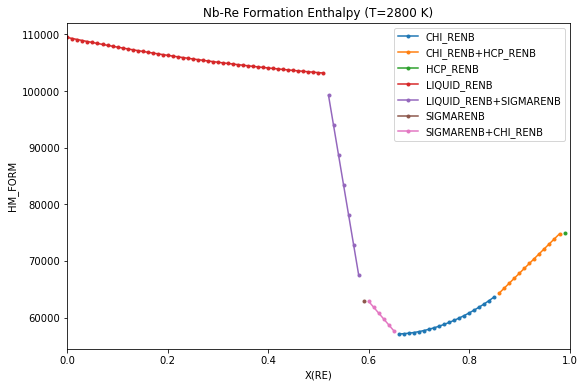

In [3]:
from pycalphad import Database, equilibrium, Model, ReferenceState, variables as v
import matplotlib.pyplot as plt
import numpy as np

dbf = Database("databases/nbre_liu.tdb")
comps = ["NB", "RE", "VA"]
phases = dbf.phases.keys()

# Create reference states
Nb_ref = ReferenceState("NB", "BCC_RENB", {v.T: 298.15, v.P: 101325})
Re_ref = ReferenceState("RE", "HCP_RENB", {v.T: 298.15, v.P: 101325})

# Create the models for each phase and shift them all by the same reference states.
eq_models = {}
for phase_name in phases:
    mod = Model(dbf, comps, phase_name)
    mod.shift_reference_state([Nb_ref, Re_ref], dbf)
    eq_models[phase_name] = mod

# Calculate HMR at 2800 K from X(RE)=0 to X(RE)=1
conds = {v.P: 101325, v.T: 2800, v.X("RE"): (0, 1, 0.01)}
result = equilibrium(dbf, comps, phases, conds, output="HMR", model=eq_models)

# Find the groups of unique phases in equilibrium e.g. [CHI_RENB] and [CHI_RENB, HCP_RENB]
unique_phase_sets = np.unique(result.Phase.values.squeeze(), axis=0)

# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for phase_set in unique_phase_sets:
    label = '+'.join([ph for ph in phase_set if ph != ''])
    # composition indices with the same unique phase
    unique_phase_idx = np.nonzero(np.all(result.Phase.values.squeeze() == phase_set, axis=1))[0]
    masked_result = result.isel(X_RE=unique_phase_idx)
    ax.plot(masked_result.X_RE.squeeze(), masked_result.HMR.squeeze(), marker='.', label=label)
ax.set_xlim((0, 1))
ax.set_xlabel('X(RE)')
ax.set_ylabel('HM_FORM')
ax.set_title('Nb-Re Formation Enthalpy (T=2800 K)')
ax.legend()
plt.show()

## Special `_MIX` Reference State

pycalphad also includes special mixing reference state that is referenced to the endmembers for that phase with the `_MIX` suffix (`GM_MIX`, `HM_MIX`, `SM_MIX`, `CPM_MIX`). This is particularly useful for seeing how the mixing contributions from physical or excess models affect the energy. The `_MIX` properties are set by default and no instantiation of `Model` objects and calling `shift_reference_state` is required.

Below is an example for calculating this endmember-referenced mixing enthalpy for the $\chi$ phase in Nb-Re. Notice that the four endmembers have a mixing enthalpy of zero.

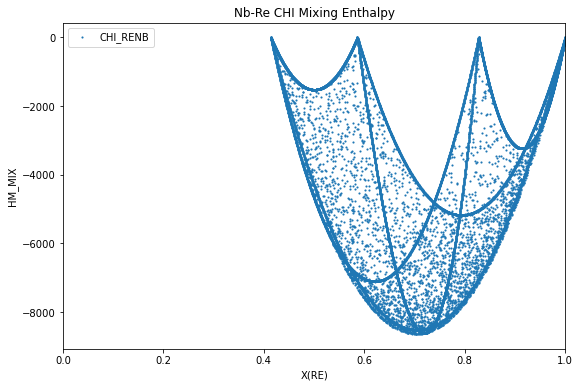

In [4]:
from pycalphad import Database, calculate
import matplotlib.pyplot as plt

dbf = Database("databases/nbre_liu.tdb")
comps = ["NB", "RE", "VA"]

# Calculate HMR for the Chi at 2800 K from X(RE)=0 to X(RE)=1
result = calculate(dbf, comps, "CHI_RENB", P=101325, T=2800, output='HM_MIX')

# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
ax.scatter(result.X.sel(component='RE'), result.HM_MIX, marker='.', s=5, label='CHI_RENB')
ax.set_xlim((0, 1))
ax.set_xlabel('X(RE)')
ax.set_ylabel('HM_MIX')
ax.set_title('Nb-Re CHI Mixing Enthalpy')
ax.legend()
plt.show()

## Calculations at specific site fractions

In the previous example, the mixing energy for the CHI phase in Nb-Re is sampled by sampling site fractions linearly between endmembers and then randomly across site fraction space.

Imagine now that you'd like to calculate the mixing energy along a single internal degree of freedom (i.e. between two endmembers), referenced to those endmembers.

A custom 2D site fraction array can be passed to the `points` argument of `calculate` and the `HM_MIX` property can be calculated as above.

The sublattice model for CHI is `RE : NB,RE : NB,RE`.

If we are interested in the interaction along the second sublattice when NB occupies the third sublattice, we need to construct a site fraction array of 

```python
# RE, NB, RE, NB, RE
[ 1.0, x, 1-x, 1.0, 0.0 ]
```

where `x` varies from 0 to 1. This fixes the site fraction of RE in the first sublattice to 1 and the site fractions of NB and RE in the third sublattice to 1 and 0, respectively. Note that the site fraction array is sorted first in sublattice order, then in alphabetic order within each sublattice (e.g. NB is always before RE within a sublattice)



Site fractions:
[[1.00e+00 1.00e-12 1.00e+00 1.00e+00 0.00e+00]
 [1.00e+00 1.00e-03 9.99e-01 1.00e+00 0.00e+00]
 [1.00e+00 2.00e-03 9.98e-01 1.00e+00 0.00e+00]
 ...
 [1.00e+00 9.98e-01 2.00e-03 1.00e+00 0.00e+00]
 [1.00e+00 9.99e-01 1.00e-03 1.00e+00 0.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00]]
Site fractions shape: (1001, 5) (1001 points, 5 internal degrees of freedom)


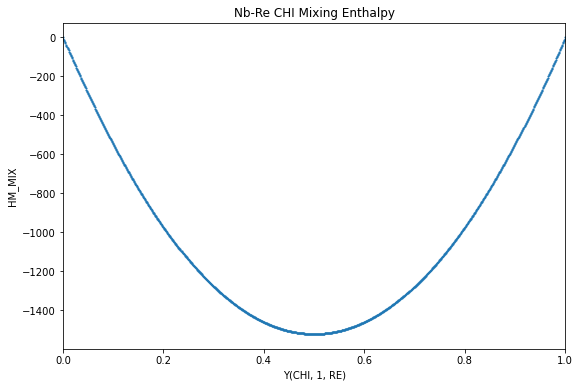

In [5]:
from pycalphad import Database, calculate
import numpy as np
import matplotlib.pyplot as plt

dbf = Database("databases/nbre_liu.tdb")
comps = ["NB", "RE", "VA"]

# The values for the internal degree of freedom we will vary
n_pts = 1001
x = np.linspace(1e-12, 1, n_pts)

# Create the site fractions
# The site fraction array is ordered first by sublattice, then alphabetically be species within a sublattice.
# The site fraction array is therefore `[RE#0, NB#1, RE#1, NB#2, RE#2]`, where `#0` is the sublattice at index 0.
# To calculate a RE:NB,RE:NB interaction requires the site fraction array to be [1, x, 1-x, 1, 0]
# Note the 1-x is required for site fractions to sum to 1 in sublattice #1.
site_fractions = np.array([np.ones(n_pts), x, 1-x, np.ones(n_pts), np.zeros(n_pts)]).T
print('Site fractions:')
print(site_fractions)
print('Site fractions shape: {} ({} points, {} internal degrees of freedom)'.format(site_fractions.shape, site_fractions.shape[0], site_fractions.shape[1]))

# Calculate HMR for the Chi at 2800 K from Y(CHI, 1, RE)=0 to Y(CHI, 1, RE)=1
# Pass the custom site fractions to the `points` argument
result = calculate(dbf, comps, "CHI_RENB", P=101325, T=2800, points=site_fractions, output='HM_MIX')
# Extract the site fractions of RE in sublattice 1.
Y_CHI_1_RE = result.Y.squeeze()[:, 2]

# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.scatter(Y_CHI_1_RE, result.HM_MIX, marker='.', s=5)
ax.set_xlim((0, 1))
ax.set_xlabel('Y(CHI, 1, RE)')
ax.set_ylabel('HM_MIX')
ax.set_title('Nb-Re CHI Mixing Enthalpy')
plt.show()